# 1. Ground heat transfer
The representation of the borehole wall temperature along a borehole using basis functions is compared to a reference solution.

In [1]:
# Import necessary packages
import geothermsim as gs

from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad_vec
from scipy.special import erfc, roots_legendre

## 1.1. Borehole trajectory
The borehole, of radius $r_b=0.075$ m, follows a curved path given by:
$$
\vec{p}(\xi) = 5 \xi^3 \vec{\imath} + 3.5 (\xi + 1)^2 \vec{\jmath} - (79 + 75 \xi) \vec{k}
$$

In [2]:
r_b = 0.075
f_px = lambda _eta: 5 * _eta**3
f_py = lambda _eta: 3.5 * (_eta + 1)**2
f_pz = lambda _eta: -79. - 75 * _eta
f_p = lambda _eta: jnp.stack([f_px(_eta), f_py(_eta), f_pz(_eta)], axis=1)
xi_path = jnp.linspace(-1., 1., num=4)
path = gs.Path(xi_path, f_p(xi_path))

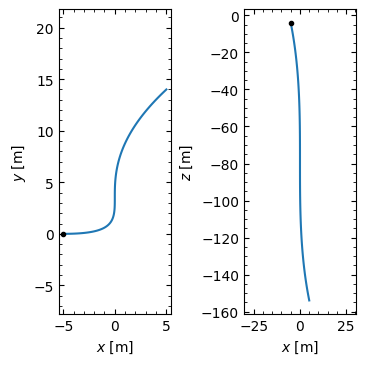

In [3]:
# Plot trajectory
fig, axs = plt.subplots(nrows=1, ncols=2, layout='constrained')
axs[0] = gs.plot.plot_path(path, ax=axs[0], view='xy')
# axs[0].set_title('Top view');
axs[1] = gs.plot.plot_path(path, ax=axs[1], view='xz')
# axs[1].set_title('Side view');
fig.set_size_inches(90. / 25.4, 90. / 25.4)
fig.savefig('trajectory-ground-heat-transfer.eps')

## 1.2. Reference solution
The reference solution is evaluated at $51$ coordinates corresponding to the gauss-legendre quadrature nodes.

In [4]:
n_eval = 51
xi, w = roots_legendre(n_eval)
xi = jnp.array(xi)
w = jnp.array(w)

The heat extraction rate along the borehole is given by:
$$
q^\prime(\xi) = 5 + \xi^{(N-1)}
$$
where $q^\prime(\xi)$ is in $[W/m]$ and $N$ is the number of nodes per segment in the borehole discretization.

The exponent power $N-1$ guarantees that the heat extraction rate can be represented by the basis functions, and thus the comparison of the borehole wall temperature is not affected by the representation of the heat extraction rate.

The point source solution, to be integrated along the trajectory of the borehole, is given by:
$$
\frac{dh}{d\xi}(t) = \frac{1}{2} \left[
\frac{1}{r} \text{erfc}\left(\frac{r}{4 \alpha t}\right)
- \frac{1}{r^\prime} \text{erfc}\left(\frac{r^\prime}{4 \alpha t}\right)
\right]
\| J(\xi) \|
$$

and the borehole wall temperature change by:
$$
\Delta T_b(t) = \int_{-1}^{1} q^\prime(\xi) \frac{dh}{d\xi}(t) d\xi
$$

In [5]:
def point_heat_source(_eta, p, time, alpha, r_min):
    # Current position of the point source
    p_source = path.f_p(_eta)
    # Distance to the real point (p)
    r = np.sqrt(np.linalg.norm(p_source - p, axis=-1)**2 + r_min**2)
    # Distance to the mirror point (p')
    r_mirror = jnp.linalg.norm(p_source - p * np.array([1, 1, -1]), axis=-1)
    # Point heat source solution
    h = 0.5 * erfc(r / jnp.sqrt(4 * alpha * time)) / r - 0.5 * erfc(r_mirror / jnp.sqrt(4 * alpha * time)) / r_mirror
    return h * path.f_J(_eta)

The reference solution is evaluated at a time $t = 20$ years for values of $N$ ranging from 1 to 11.

The calculation of the reference may take several minutes to complete.

In [6]:
time = 20 * 8760 * 3600.
alpha = 1e-6
N = 11

In [7]:
f_q = lambda _eta, _N: 5 + _eta**(_N - 1)
p = path.f_p(xi)
dT_b_ref = []
for _N in range(1, N + 1):
    integrand = lambda _eta: point_heat_source(_eta, p, time, alpha, r_b) * f_q(_eta, _N)
    dT_b_ref.append(quad_vec(integrand, -1., 1., points=xi)[0])
dT_b_ref = jnp.stack(dT_b_ref, axis=1)

## 1.3. Solution using geothermsim
The solution is also evaluated using geothermsim for the same values of $N$ ranging from 1 to 11 and for numbers of segments $S$ ranging from 1 to 5.

In [8]:
S = 5
dT_b_nodes = []
dT_b_model = []
boreholes = []
for _S in range(1, S + 1):
    for _N in range(1, N + 1):
        basis = gs.Basis.Legendre(_N, order=101, order_nodes=101)
        borehole = gs.Borehole(r_b, path, basis, _S)
        boreholes.append(borehole)
        q_nodes = f_q(borehole.xi, _N)
        h_to_self = borehole.h_to_self(jnp.array([time]), alpha)
        dT_b_nodes.append((h_to_self @ q_nodes).flatten())
        dT_b_model.append(borehole.f(xi, dT_b_nodes[-1]))
dT_b_model = jnp.concatenate(dT_b_model).reshape(S, N, n_eval).T

## 1.4. Comparison between the reference and geothermsim solutions
The borehole wall temperature profile is compared to the reference for $S=5$ and $N=11$.

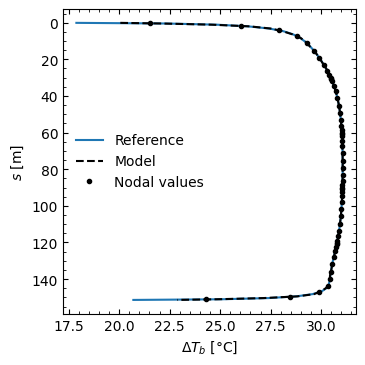

In [9]:
# Plot borehole wall temperature change
fig, ax = plt.subplots(layout='constrained')
gs.plot._format_axis(ax, axis_labels=[r'$\Delta T_b$ [$\degree$C]', r'$s$ [m]'], inverse_y=True)
ax.plot(dT_b_ref[:, -1], path.f_s(xi), label='Reference');
ax.plot(dT_b_model[:, -1, -1], path.f_s(xi), 'k--', label='Model');
ax.plot(dT_b_nodes[-1], boreholes[-1].s, 'k.', label='Nodal values');
ax.legend(frameon=False);
fig.set_size_inches(90. / 25.4, 90. / 25.4)
fig.savefig('temperature-ground-heat-transfer.eps')

The mean absolute percentage error (MAPE) between the reference borehole wall temperature and that evaluated by the interpolation of the model using the basis functions is given by:
$$
MAPE = \frac{1}{2} \int_{-1}^{1} \left| \frac{\Delta T_{b,reference}(\xi) - \Delta T_{b,model}(\xi)}{\Delta T_{b,reference}(\xi)} \right| d\xi \cdot 100 \%
$$

In [10]:
mape = ((jnp.abs((dT_b_ref.T - dT_b_model.T)) / dT_b_ref.T) @ w * 100).T

In [11]:
# Format and print dataframe
df_mape = pd.DataFrame(
    mape,
    columns=[f'S = {_S}' for _S in jnp.arange(1, S + 1)],
    index=jnp.arange(1, N + 1))
df_mape.index.name = 'N'
df_mape.style.set_caption('Mean Absolute Percentage Error (MAPE) [%]') 

,S = 1,S = 2,S = 3,S = 4,S = 5
N,,,,,
1,8.517573,7.935043,6.850122,5.997212,5.302423
2,7.888798,5.429883,3.911536,3.054612,2.473177
3,4.887159,3.554971,2.301007,1.719080,1.362259
4,4.147348,1.994583,1.324289,0.990967,0.784752
5,2.349000,1.519446,0.977689,0.713671,0.580424
6,1.989399,0.994609,0.653863,0.494122,0.388508
7,1.376024,0.841635,0.543337,0.407469,0.338217
8,1.174559,0.609587,0.400060,0.309299,0.245651
9,0.912480,0.542207,0.363706,0.264073,0.205421


The root mean square error (RMSE) can also be evaluated:
$$
RMSE = \sqrt{\frac{1}{2} \int_{-1}^{1} \left[ \Delta T_{b,reference}(\xi) - \Delta T_{b,model}(\xi) \right]^2 d\xi}
$$

In [12]:
rmse = jnp.sqrt((dT_b_ref.T - dT_b_model.T)**2 @ w).T

In [13]:
# Format and print dataframe
df_rmse = pd.DataFrame(
    rmse,
    columns=[f'S = {_S}' for _S in jnp.arange(1, S + 1)],
    index=jnp.arange(1, N + 1))
df_rmse.index.name = 'N'
df_rmse.style.set_caption(r'Root Mean Square Error (RMSE) $[\degree \text{C}]$') 

,S = 1,S = 2,S = 3,S = 4,S = 5
N,,,,,
1,3.790997,3.558441,3.228359,2.940907,2.703544
2,2.775103,2.052560,1.669920,1.427187,1.258578
3,2.440147,1.718494,1.336522,1.120822,0.978339
4,1.635607,1.027212,0.808244,0.681655,0.595983
5,1.429540,0.965184,0.751789,0.628529,0.545232
6,1.013631,0.656255,0.512113,0.426518,0.367861
7,0.988661,0.655733,0.504774,0.415618,0.354647
8,0.727877,0.469650,0.359546,0.293455,0.247936
9,0.744948,0.482579,0.363742,0.292708,0.243827
